<a href="https://colab.research.google.com/github/sayakpaul/TF-2.0-Hacks/blob/master/data2vec_vision_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook, we'll fine-tune a model pre-trained using data2vec. We'll leverage the `transformers` library for loading the pre-trained model and we'll then append a custom classification head for fine-tuning. For data handling we'll use `tf.data`.

Checkout the data2vec paper [here](https://arxiv.org/abs/2202.03555) and the model documentation page [here](https://huggingface.co/docs/transformers/main/en/model_doc/data2vec).

## Setup

In [1]:
# Otherwise TF's data2vec vision model won't be available.
# Date: May 06, 2022
!pip install git+https://github.com/huggingface/transformers -q

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 6.6 MB 3.3 MB/s 
     |████████████████████████████████| 77 kB 4.8 MB/s 
     |████████████████████████████████| 596 kB 39.0 MB/s 


## Imports

In [2]:
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras import layers

from transformers import TFAutoModelForImageClassification, TFData2VecVisionModel
from transformers import create_optimizer

import tensorflow_datasets as tfds

tfds.disable_progress_bar()

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Primary constants

In [3]:
# Model
IMAGE_SIZE = [224, 224]
MODEL_ID = "facebook/data2vec-vision-base"  # pre-trained model from which to fine-tune

# Data
BATCH_SIZE = 16  # on Colab/GPU, a higher batch size may throw(OOM)

# Dataset
CLASSES = [
    "dandelion",
    "daisy",
    "tulips",
    "sunflowers",
    "roses",
]  # don't change the order

# Other constants
MEAN = tf.constant([0.485 * 255, 0.456 * 255, 0.406 * 255])  # imagenet mean
STD = tf.constant([0.229 * 255, 0.224 * 255, 0.225 * 255])  # imagenet std
AUTO = tf.data.AUTOTUNE

## Data related utilities

In [4]:
# Closely aligns with https://github.com/huggingface/transformers/blob/main/src/transformers/models/beit/feature_extraction_beit.py
# in regards to resizing and normalization.


def make_dataset(dataset: tf.data.Dataset, train: bool, image_size: int = IMAGE_SIZE):
    def preprocess(image, label):
        # for training, do augmentation
        if train:
            if tf.random.uniform(shape=[]) > 0.5:
                image = tf.image.flip_left_right(image)
        image = tf.image.resize(image, size=image_size, method="bicubic")
        image = (image - MEAN) / STD  # normalization
        return image, label

    if train:
        dataset = dataset.shuffle(BATCH_SIZE * 10)

    dataset = dataset.map(preprocess, AUTO).batch(BATCH_SIZE)
    # Transpose because the `transformers` model has a leading channel dimension.
    dataset = dataset.map(lambda x, y: (tf.transpose(x, [0, 3, 1, 2]), y), AUTO)
    return dataset.prefetch(AUTO)

## Load and visualize the `tf_flowers` dataset

In [5]:
train_dataset, val_dataset = tfds.load(
    "tf_flowers",
    split=["train[:90%]", "train[90%:]"],
    as_supervised=True,
    try_gcs=False,  # gcs_path is necessary for tpu,
)

num_train = tf.data.experimental.cardinality(train_dataset)
num_val = tf.data.experimental.cardinality(val_dataset)
print(f"Number of training examples: {num_train}")
print(f"Number of validation examples: {num_val}")

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.
Number of training examples: 3303
Number of validation examples: 367


In [6]:
train_dataset = make_dataset(train_dataset, True)
val_dataset = make_dataset(val_dataset, False)

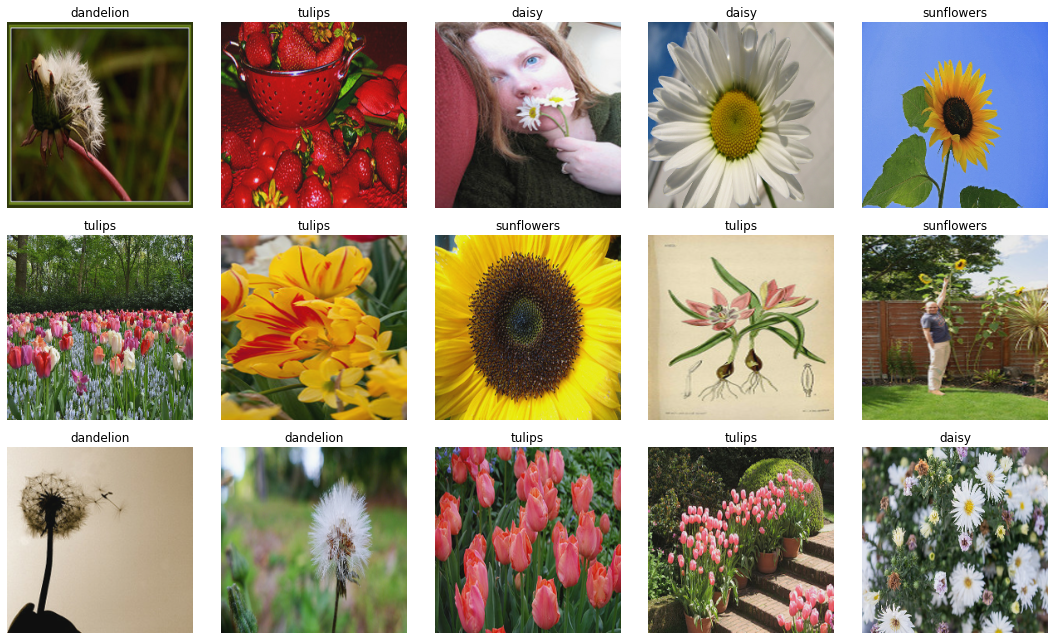

In [7]:
sample_images, sample_labels = next(iter(train_dataset))

plt.figure(figsize=(5 * 3, 3 * 3))
for n in range(15):
    ax = plt.subplot(3, 5, n + 1)
    image = (sample_images[n].numpy().transpose(1, 2, 0) * STD + MEAN).numpy()
    image = (image - image.min()) / (
        image.max() - image.min()
    )  # convert to [0, 1] for avoiding matplotlib warning
    plt.imshow(image)
    plt.title(CLASSES[sample_labels[n]])
    plt.axis("off")
plt.tight_layout()
plt.show()

## Model building utilities

In [8]:
def get_model():
    base_model = TFData2VecVisionModel.from_pretrained(MODEL_ID)
    base_model.trainable = True

    inputs = layers.Input((3, IMAGE_SIZE[0], IMAGE_SIZE[1]))
    x = base_model(inputs, training=False)
    outputs = layers.Dense(5)(x.last_hidden_state[:, 0])
    model = keras.Model(inputs, outputs)

    return model

In [9]:
model = get_model()
model.summary()

Downloading:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/327M [00:00<?, ?B/s]

Some layers from the model checkpoint at facebook/data2vec-vision-base were not used when initializing TFData2VecVisionModel: ['classifier']
- This IS expected if you are initializing TFData2VecVisionModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFData2VecVisionModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFData2VecVisionModel were initialized from the model checkpoint at facebook/data2vec-vision-base.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFData2VecVisionModel for predictions without further training.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3, 224, 224)]     0         
                                                                 
 tf_data2_vec_vision_model (  TFData2VecVisionModelOut  85665360 
 TFData2VecVisionModel)      putWithPooling(last_hidd            
                             en_state=(None, 197, 768            
                             ),                                  
                              pooler_output=None, hid            
                             den_states=None, attenti            
                             ons=None)                           
                                                                 
 tf.__operators__.getitem (S  (None, 768)              0         
 licingOpLambda)                                                 
                                                             

## Compile model and train it

In [10]:
num_train_epochs = 3
learning_rate = 3e-5
weight_decay_rate = 0.01
num_warmup_steps = 0


num_train_steps = num_train * num_train_epochs
optimizer, lr_schedule = create_optimizer(
    init_lr=learning_rate,
    num_train_steps=num_train_steps,
    weight_decay_rate=weight_decay_rate,
    num_warmup_steps=num_warmup_steps,
)

In [11]:
model.compile(
    optimizer=optimizer,
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

In [12]:
history = model.fit(train_dataset, validation_data=val_dataset, epochs=num_train_epochs)

Epoch 1/3
207/207 [==============================] - 307s 1s/step - loss: 0.7240 - accuracy: 0.7215 - val_loss: 0.2655 - val_accuracy: 0.9155
Epoch 2/3
207/207 [==============================] - 280s 1s/step - loss: 0.2162 - accuracy: 0.9282 - val_loss: 0.1680 - val_accuracy: 0.9401
Epoch 3/3
207/207 [==============================] - 280s 1s/step - loss: 0.1052 - accuracy: 0.9667 - val_loss: 0.2620 - val_accuracy: 0.9046


## Visualize training progress

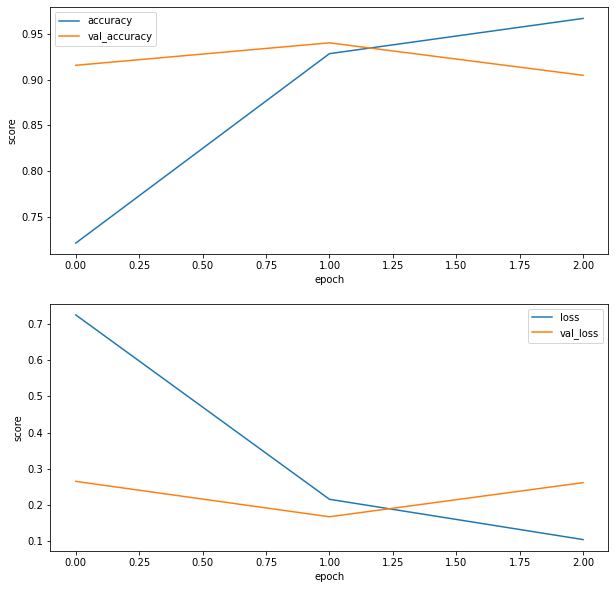

In [13]:
result = pd.DataFrame(history.history)
fig, ax = plt.subplots(2, 1, figsize=(10, 10))
result[["accuracy", "val_accuracy"]].plot(xlabel="epoch", ylabel="score", ax=ax[0])
result[["loss", "val_loss"]].plot(xlabel="epoch", ylabel="score", ax=ax[1])

## References

* https://github.com/sayakpaul/cait-tf/blob/main/notebooks/finetune.ipynb
* https://colab.research.google.com/drive/1M4CEl6Jgf4KgqLHb4_bi3acJvNNLZqZd